Linear Regression Model

Training linear model w/ season stats…


/var/folders/5h/hync6fln3c9b7kcqm3klnnv00000gn/T/ipykernel_13200/3500954168.py:102: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].mean(), inplace=True)



Linear Regression + season stats Evaluation:
  MSE = 11.320
  MAE = 2.609
  R²  = 0.261


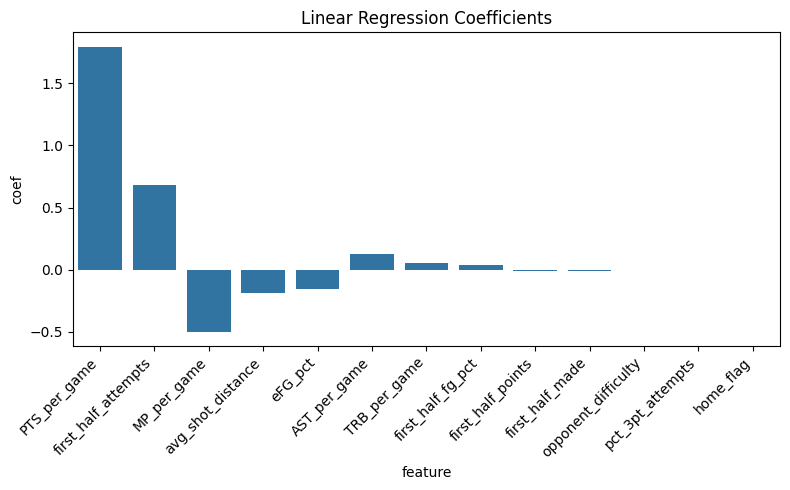

Model and scaler saved.

Predicted 2H points for lebron james: 9.06


/var/folders/5h/hync6fln3c9b7kcqm3klnnv00000gn/T/ipykernel_13200/3500954168.py:198: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pf[col].fillna(season_df[col].mean(), inplace=True)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import pathlib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing    import StandardScaler
from sklearn.linear_model     import LinearRegression
from sklearn.metrics          import mean_squared_error, mean_absolute_error, r2_score

def find_csv(filename: str) -> pathlib.Path:
    """Look for filename in project root and in Datasets/."""
    candidates = [
        pathlib.Path(filename),
        pathlib.Path("Datasets") / filename
    ]
    for p in candidates:
        if p.exists():
            return p
    raise FileNotFoundError(f"Could not find {filename} in root or Datasets/")

def load_season_averages():
    folder = pathlib.Path("Datasets") / "NBA dataset 23-24 (NEW)"
    if not folder.exists():
        raise FileNotFoundError(f"{folder} not found.")
    dfs = []
    for f in folder.glob("*.csv"):
        df = pd.read_csv(f)
        if "Player" in df.columns:
            df = df.rename(columns={"Player": "PLAYER_NAME"})
        dfs.append(df)
    season_df = pd.concat(dfs, ignore_index=True)
    return season_df.rename(columns={
        "MP":   "MP_per_game",
        "PTS":  "PTS_per_game",
        "AST":  "AST_per_game",
        "TRB":  "TRB_per_game",
        "eFG%": "eFG_pct"
    })[["PLAYER_NAME","MP_per_game","PTS_per_game","AST_per_game","TRB_per_game","eFG_pct"]]

def train_model():
    # Load shot‑chart data
    shot_path = find_csv("23-24 NBA dataset.csv")
    nba_df = pd.read_csv(shot_path)
    for c in ['SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']:
        nba_df[c] = nba_df[c].astype(int)
    for c in ['SHOT_TYPE','PLAYER_NAME','TEAM_NAME','HOME_TEAM_NAME','AWAY_TEAM_NAME','LOCATION']:
        nba_df[c] = nba_df[c].astype(str)

    nba_df['OPPONENT_TEAM'] = np.where(
        nba_df['TEAM_NAME']==nba_df['HOME_TEAM_NAME'],
        nba_df['AWAY_TEAM_NAME'],
        nba_df['HOME_TEAM_NAME']
    )
    nba_df['home_flag'] = (nba_df['LOCATION']=='Home').astype(int)

    shots = nba_df[nba_df['SHOT_ATTEMPTED_FLAG']==1].copy()
    shots['POINTS'] = np.where(
        (shots['SHOT_MADE_FLAG']==1)&(shots['SHOT_TYPE']=='3PT'), 3,
        np.where(shots['SHOT_MADE_FLAG']==1, 2, 0)
    )

    # First‑half summary
    fh = shots[shots['PERIOD'].isin([1,2])]
    first_half = fh.groupby(
        ['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM']
    ).agg(
        first_half_attempts=('SHOT_ATTEMPTED_FLAG','sum'),
        first_half_made     =('SHOT_MADE_FLAG','sum'),
        first_half_points   =('POINTS','sum'),
        first_half_fg_pct   =('SHOT_MADE_FLAG', lambda s: s.sum()/len(s) if len(s)>0 else 0),
        avg_shot_distance   =('SHOT_DISTANCE','mean'),
        pct_3pt_attempts    =('SHOT_TYPE', lambda s:(s=='3PT').mean()),
        home_flag           =('home_flag','max')
    ).reset_index()

    # Second‑half summary
    sh = shots[shots['PERIOD'].isin([3,4])]
    second_half = sh.groupby(
        ['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM']
    ).agg(second_half_points=('POINTS','sum')).reset_index()

    data = pd.merge(first_half, second_half, how='inner',
                    on=['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM'])

    # Opponent difficulty
    ranking_path = find_csv("23-24 NBA RANKING.csv")
    ranking = pd.read_csv(ranking_path)
    ranking['TEAM_NAME'] = ranking['TEAM_NAME'].str.strip()
    data = data.merge(ranking, left_on='OPPONENT_TEAM', right_on='TEAM_NAME', how='left')
    data['opponent_difficulty'] = data['OVR_RANK'].apply(lambda r: 1/r if r>0 else 0)

    # Season averages
    season_df = load_season_averages()
    data = data.merge(season_df, on='PLAYER_NAME', how='left')

    # Impute any missing season stats
    for col in ['MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct']:
        data[col].fillna(data[col].mean(), inplace=True)

    # Prepare features & target
    feature_cols = [
        'first_half_attempts','first_half_made','first_half_points','first_half_fg_pct',
        'avg_shot_distance','pct_3pt_attempts','home_flag','opponent_difficulty',
        'MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct'
    ]
    X = data[feature_cols]
    y = data['second_half_points']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    lr = LinearRegression()
    lr.fit(X_train_s, y_train)

    # Evaluate
    y_pred = lr.predict(X_test_s)
    print("\nLinear Regression + season stats Evaluation:")
    print(f"  MSE = {mean_squared_error(y_test, y_pred):.3f}")
    print(f"  MAE = {mean_absolute_error(y_test, y_pred):.3f}")
    print(f"  R²  = {r2_score(y_test, y_pred):.3f}")

    coef_df = pd.DataFrame({'feature': feature_cols, 'coef': lr.coef_})\
               .sort_values('coef', key=abs, ascending=False)
    plt.figure(figsize=(8,5))
    sns.barplot(data=coef_df, x='feature', y='coef')
    plt.xticks(rotation=45, ha='right')
    plt.title("Linear Regression Coefficients")
    plt.tight_layout()
    plt.show()

    joblib.dump(lr, 'player_performance_predictor.pkl')
    joblib.dump(scaler, 'scaler.pkl')
    print("Model and scaler saved.")

def predict_player_performance(name: str):
    shot_path    = find_csv("23-24 NBA dataset.csv")
    ranking_path = find_csv("23-24 NBA RANKING.csv")

    lr         = joblib.load('player_performance_predictor.pkl')
    scaler     = joblib.load('scaler.pkl')
    season_df  = load_season_averages()

    nba_df = pd.read_csv(shot_path)
    for c in ['SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']:
        nba_df[c] = nba_df[c].astype(int)
    for c in ['SHOT_TYPE','PLAYER_NAME','TEAM_NAME','HOME_TEAM_NAME','AWAY_TEAM_NAME','LOCATION']:
        nba_df[c] = nba_df[c].astype(str)

    nba_df['OPPONENT_TEAM'] = np.where(
        nba_df['TEAM_NAME']==nba_df['HOME_TEAM_NAME'],
        nba_df['AWAY_TEAM_NAME'],
        nba_df['HOME_TEAM_NAME']
    )
    nba_df['home_flag'] = (nba_df['LOCATION']=='Home').astype(int)

    shots = nba_df[nba_df['SHOT_ATTEMPTED_FLAG']==1].copy()
    shots['POINTS'] = np.where(
        (shots['SHOT_MADE_FLAG']==1)&(shots['SHOT_TYPE']=='3PT'), 3,
        np.where(shots['SHOT_MADE_FLAG']==1, 2, 0)
    )

    fh = shots[shots['PERIOD'].isin([1,2])]
    first_half = fh.groupby(
        ['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM']
    ).agg(
        first_half_attempts=('SHOT_ATTEMPTED_FLAG','sum'),
        first_half_made     =('SHOT_MADE_FLAG','sum'),
        first_half_points   =('POINTS','sum'),
        first_half_fg_pct   =('SHOT_MADE_FLAG', lambda s: s.sum()/len(s) if len(s)>0 else 0),
        avg_shot_distance   =('SHOT_DISTANCE','mean'),
        pct_3pt_attempts    =('SHOT_TYPE', lambda s:(s=='3PT').mean()),
        home_flag           =('home_flag','max')
    ).reset_index()

    ranking = pd.read_csv(ranking_path)
    ranking['TEAM_NAME'] = ranking['TEAM_NAME'].str.strip()
    first_half = first_half.merge(
        ranking, left_on='OPPONENT_TEAM', right_on='TEAM_NAME', how='left'
    )
    first_half['opponent_difficulty'] = first_half['OVR_RANK'].apply(lambda r: 1/r if r>0 else 0)

    pf = first_half[first_half['PLAYER_NAME'].str.upper()==name.upper()]
    if pf.empty:
        print(f"No data for {name}")
        return

    pf = pf.merge(season_df, on='PLAYER_NAME', how='left')
    # Impute missing season stats
    for col in ['MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct']:
        pf[col].fillna(season_df[col].mean(), inplace=True)

    feature_cols = [
        'first_half_attempts','first_half_made','first_half_points','first_half_fg_pct',
        'avg_shot_distance','pct_3pt_attempts','home_flag','opponent_difficulty',
        'MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct'
    ]
    Xp = pf[feature_cols].iloc[[0]]
    Xp_s = scaler.transform(Xp)
    pred = lr.predict(Xp_s)[0]
    print(f"\nPredicted 2H points for {name}: {pred:.2f}")

def main():
    print("Training linear model w/ season stats…")
    train_model()
    name = input("\nEnter player name to predict: ").strip()
    if name:
        predict_player_performance(name)

if __name__ == "__main__":
    main()


Predicted second half points of Lebron James VS. Opponent and their difficulty (uses XGBRegressor)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import joblib
import os
import pathlib

from sklearn.linear_model  import LinearRegression
from sklearn.preprocessing import StandardScaler

# -----------------------------------
# Helpers
# -----------------------------------
def find_csv(filename: str) -> pathlib.Path:
    """Look for filename in project root or Datasets/."""
    for candidate in (
        pathlib.Path(filename),
        pathlib.Path("Datasets") / filename
    ):
        if candidate.exists():
            return candidate
    raise FileNotFoundError(f"Could not find {filename}")

def load_season_averages() -> pd.DataFrame:
    """Concatenate all per‑game CSVs under Datasets/NBA dataset 23‑24 (NEW)."""
    folder = pathlib.Path("Datasets") / "NBA dataset 23-24 (NEW)"
    if not folder.exists():
        raise FileNotFoundError(f"{folder} not found.")
    dfs = []
    for f in folder.glob("*.csv"):
        df = pd.read_csv(f)
        if "Player" in df.columns:
            df = df.rename(columns={"Player": "PLAYER_NAME"})
        dfs.append(df)
    season_df = pd.concat(dfs, ignore_index=True)
    return season_df.rename(columns={
        "MP":   "MP_per_game",
        "PTS":  "PTS_per_game",
        "AST":  "AST_per_game",
        "TRB":  "TRB_per_game",
        "eFG%": "eFG_pct"
    })[["PLAYER_NAME","MP_per_game","PTS_per_game","AST_per_game","TRB_per_game","eFG_pct"]]

# -----------------------------------
# Team‑code → full name map
# -----------------------------------
team_name_map = {
    "ATL":"Atlanta Hawks","BOS":"Boston Celtics","BKN":"Brooklyn Nets",
    "CHA":"Charlotte Hornets","CHI":"Chicago Bulls","CLE":"Cleveland Cavaliers",
    "DAL":"Dallas Mavericks","DEN":"Denver Nuggets","DET":"Detroit Pistons",
    "GSW":"Golden State Warriors","HOU":"Houston Rockets","IND":"Indiana Pacers",
    "LAC":"Los Angeles Clippers","LAL":"Los Angeles Lakers","MEM":"Memphis Grizzlies",
    "MIA":"Miami Heat","MIL":"Milwaukee Bucks","MIN":"Minnesota Timberwolves",
    "NOP":"New Orleans Pelicans","NYK":"New York Knicks","OKC":"Oklahoma City Thunder",
    "ORL":"Orlando Magic","PHI":"Philadelphia 76ers","PHX":"Phoenix Suns",
    "POR":"Portland Trail Blazers","SAC":"Sacramento Kings","SAS":"San Antonio Spurs",
    "TOR":"Toronto Raptors","UTA":"Utah Jazz","WAS":"Washington Wizards"
}

# -----------------------------------
# Load your LinearRegression model & scaler
# -----------------------------------
if not (os.path.exists('linear_performance_predictor.pkl')
        and os.path.exists('linear_scaler.pkl')):
    raise FileNotFoundError(
      "Please run your linear train script to produce "
      "'linear_performance_predictor.pkl' and 'linear_scaler.pkl'"
    )
model  = joblib.load('linear_performance_predictor.pkl')
scaler = joblib.load('linear_scaler.pkl')

# (Optional) sanity check:
from sklearn.linear_model import LinearRegression
if not isinstance(model, LinearRegression):
    raise RuntimeError("Loaded pickle is not a LinearRegression!")
# -----------------------------------
# Read shot‑chart & ranking data
# -----------------------------------
shots_csv   = find_csv("23-24 NBA dataset.csv")
ranking_csv = find_csv("23-24 NBA RANKING.csv")

nba_df     = pd.read_csv(shots_csv)
ranking_df = pd.read_csv(ranking_csv)

# enforce dtypes
for c in ['SHOT_ATTEMPTED_FLAG','SHOT_MADE_FLAG']:
    nba_df[c] = nba_df[c].astype(int)
for c in ['SHOT_TYPE','PLAYER_NAME','TEAM_NAME','HOME_TEAM_NAME','AWAY_TEAM_NAME','LOCATION']:
    nba_df[c] = nba_df[c].astype(str)

# determine opponent & home_flag
nba_df['OPPONENT_TEAM'] = (
    nba_df['AWAY_TEAM_NAME']
    .where(nba_df['TEAM_NAME']==nba_df['HOME_TEAM_NAME'],
           nba_df['HOME_TEAM_NAME'])
    .str.strip()
)
nba_df['OPPONENT_TEAM_FULL'] = (
    nba_df['OPPONENT_TEAM']
    .map(team_name_map)
    .fillna(nba_df['OPPONENT_TEAM'])
)
nba_df['home_flag'] = (nba_df['LOCATION']=='Home').astype(int)

# keep only shot attempts & compute POINTS
shots = nba_df[nba_df['SHOT_ATTEMPTED_FLAG']==1].copy()
shots['POINTS'] = np.where(
    (shots['SHOT_MADE_FLAG']==1)&(shots['SHOT_TYPE']=='3PT'), 3,
    np.where(shots['SHOT_MADE_FLAG']==1, 2, 0)
)

# -----------------------------------
# First‑ vs Second‑Half Aggregation
# -----------------------------------
grouped = shots.groupby(
    ['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM_FULL','PERIOD']
).agg(
    attempts=('SHOT_ATTEMPTED_FLAG','sum'),
    made    =('SHOT_MADE_FLAG','sum'),
    points  =('POINTS','sum')
).reset_index()

first_half = (
    grouped[grouped['PERIOD'].isin([1,2])]
    .groupby(['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM_FULL'])
    .agg(
        first_half_attempts=('attempts','sum'),
        first_half_made     =('made','sum'),
        first_half_points   =('points','sum')
    )
    .reset_index()
)

second_half = (
    grouped[grouped['PERIOD'].isin([3,4])]
    .groupby(['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM_FULL'])
    .agg(second_half_points=('points','sum'))
    .reset_index()
)

game_player_data = pd.merge(
    first_half, second_half,
    on=['GAME_ID','PLAYER_NAME','TEAM_NAME','OPPONENT_TEAM_FULL'],
    how='inner'
)
game_player_data['first_half_fg_pct'] = np.where(
    game_player_data['first_half_attempts']>0,
    game_player_data['first_half_made']/game_player_data['first_half_attempts'],
    0
)

# -----------------------------------
# Opponent Difficulty
# -----------------------------------
ranking_df['TEAM_NAME'] = ranking_df['TEAM_NAME'].str.strip()
game_player_data = pd.merge(
    game_player_data, ranking_df,
    left_on='OPPONENT_TEAM_FULL', right_on='TEAM_NAME', how='left'
)
game_player_data['opponent_difficulty'] = game_player_data['OVR_RANK'].apply(
    lambda r: 1/r if r>0 else 0
)

# -----------------------------------
# Filter to your player (e.g. LeBron)
# -----------------------------------
player_name = "LeBron James"
player_df   = game_player_data[
    game_player_data['PLAYER_NAME'].str.upper()==player_name.upper()
]
if player_df.empty:
    raise ValueError(f"No data for {player_name}")

# extra first‑half features by opponent
lh = shots[
    (shots['PLAYER_NAME'].str.upper()==player_name.upper()) &
    (shots['PERIOD'].isin([1,2]))
]
extra = lh.groupby('OPPONENT_TEAM_FULL').agg(
    avg_shot_distance=('SHOT_DISTANCE','mean'),
    pct_3pt_attempts =('SHOT_TYPE', lambda s:(s=='3PT').mean()),
    home_flag_feat   =('home_flag','max')
).rename(columns={'home_flag_feat':'home_flag'}).reset_index()

# opponent‑level summary
opp = (
    player_df.groupby('OPPONENT_TEAM_FULL')
    .agg(
        first_half_attempts =('first_half_attempts','mean'),
        first_half_made     =('first_half_made','mean'),
        first_half_points   =('first_half_points','mean'),
        first_half_fg_pct   =('first_half_fg_pct','mean'),
        opponent_difficulty =('opponent_difficulty','mean'),
        second_half_points  =('second_half_points','mean')
    )
    .reset_index()
)
opp = pd.merge(opp, extra, on='OPPONENT_TEAM_FULL', how='left')

# -----------------------------------
# Merge in season averages for the player
# -----------------------------------
season_df    = load_season_averages()
player_stats = season_df[
    season_df['PLAYER_NAME'].str.upper()==player_name.upper()
]
if player_stats.empty:
    raise ValueError(f"No season stats for {player_name}")
stats = player_stats.iloc[0]
for col in ['MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct']:
    opp[col] = stats[col]

# -----------------------------------
# Prepare features & predict with LinearRegression
# -----------------------------------
feature_cols = [
    'first_half_attempts','first_half_made','first_half_points','first_half_fg_pct',
    'avg_shot_distance','pct_3pt_attempts','home_flag','opponent_difficulty',
    'MP_per_game','PTS_per_game','AST_per_game','TRB_per_game','eFG_pct'
]
X        = opp[feature_cols]
X_scaled = scaler.transform(X)
opp['predicted_second_half_points'] = model.predict(X_scaled)

# -----------------------------------
# Plot predictions
# -----------------------------------
opp = opp.sort_values('opponent_difficulty', ascending=False)
teams      = opp['OPPONENT_TEAM_FULL']
pred_pts   = opp['predicted_second_half_points']
difficulty = opp['opponent_difficulty']

norm   = mpl.colors.Normalize(difficulty.min(), difficulty.max())
cmap   = mpl.cm.plasma
colors = cmap(norm(difficulty))

fig, ax = plt.subplots(figsize=(14, 8))
bars = ax.bar(teams, pred_pts, color=colors, edgecolor='black')

for bar in bars:
    y = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, y + 0.3,
            f"{y:.1f}", ha='center', va='bottom')

ax.set_xlabel("Opponent Team")
ax.set_ylabel("Predicted 2H Points")
ax.set_ylim(0, 15)
ax.set_title(f"{player_name}: Predicted Second-Half Points vs. Opponents (Color=Difficulty)")
ax.set_xticklabels(teams, rotation=45, ha='right')
ax.grid(axis='y', linestyle='--', alpha=0.7)

sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label("Opponent Difficulty (1/OVR_RANK)")

plt.tight_layout()
plt.show()


FileNotFoundError: Please run your linear train script to produce 'linear_performance_predictor.pkl' and 'linear_scaler.pkl'